In [1]:
import rioxarray as rxr
import xarray as xr
from rasterio.plot import plotting_extent
import numpy as np
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
from pathlib import Path

import networkx as nx
import geonetworkx as gnx

from dask.distributed import Client

/tmp/ipykernel_25328/1060395582.py:5: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [2]:
# client = Client(n_workers=4)
# client

In [3]:
PLOTTING_PROJ = ccrs.PlateCarree()
DIST_PROJ = "+proj=eqdc +lon_0=-103.7988281 +lat_1=35.7127609 +lat_2=43.8942567 +lat_0=39.8035088 +datum=WGS84 +units=m +no_defs"

def geoax(figsize=(10, 5), **kwargs):
    f, ax = plt.subplots(figsize=figsize, subplot_kw={"projection": PLOTTING_PROJ}, **kwargs)
    ax.add_feature(cartopy.feature.BORDERS)
    
    return f, ax

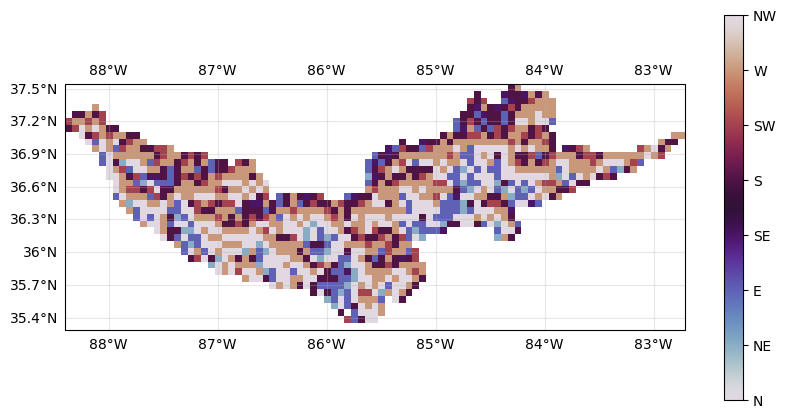

In [4]:
# read in the flow direction file
fdr = rxr.open_rasterio("../../data-cumberland/tennessee/basins/cumberland/ro/pars/fl.tif", masked=True)  # nodask
band = fdr.sel(band=1)

band_vicfmt = band  # it is already in vic-format, no need to reclassify

f, ax = geoax()
im = ax.imshow(band_vicfmt, extent=plotting_extent(band, fdr.rio.transform()), cmap='twilight')
gl = ax.gridlines(alpha=0.3, draw_labels=True)
gl.right_labels = False
cbar = f.colorbar(im, ticks=[1, 2, 3, 4, 5, 6, 7, 8])
cbar.ax.set_yticklabels(["N", "NE", "E", "SE", "S", "SW", "W", "NW"]);

In [5]:
reservoirs_fn = "../../data-cumberland/cumberland-stations/cumberland-resops-stations.csv"
reservoirs = gpd.read_file(reservoirs_fn)
reservoirs['geometry'] = gpd.points_from_xy(reservoirs['lon'], reservoirs['lat'])
reservoirs.set_crs('epsg:4326', inplace=True)

reservoirs.head()

,run,name,lat,lon,geometry
0,1,Laurel_Dam,36.959995,-84.267474,POINT (-84.26747 36.95999)
1,1,Wolf_Creek,36.867817,-85.14375,POINT (-85.14375 36.86782)
2,1,Dale_Hollow_Dam,36.538312,-85.450254,POINT (-85.45025 36.53831)
3,1,Old_Hickory_Dam,36.29189,-86.658869,POINT (-86.65887 36.29189)
4,1,Center_Hill_Dam,36.096527,-85.82558,POINT (-85.82558 36.09653)


In [6]:
reservoirs.iloc[0]

run                                    1
name                          Laurel_Dam
lat                            36.959995
lon                           -84.267474
geometry    POINT (-84.267474 36.959995)
Name: 0, dtype: object

In [7]:
# # create a raster where the pixel values specify the index of reservoirs
# sampled_xy = [xy for xy in zip(reservoirs['lon'], reservoirs['lat'])]

reservoir_location_raster = xr.full_like(band_vicfmt, np.nan)
for resid, row in reservoirs.iterrows():
    reslat = float(row.lat)
    reslon = float(row.lon)

    rast_lat = reservoir_location_raster.indexes['y'].get_indexer([reslat], method="nearest")[0]
    rast_lon = reservoir_location_raster.indexes['x'].get_indexer([reslon], method="nearest")[0]

    reservoir_location_raster[rast_lat, rast_lon] = resid

In [8]:
# type(reservoirs['geometry'])

In [9]:
# convert all points to nodes. Use index value to identify
G = nx.DiGraph()
G.add_nodes_from(reservoirs.index)

operations = {
    1: [-1, 0],  # N
    2: [-1, 1],  # NE
    3: [0, 1],   # E
    4: [1, 1],   # SE
    5: [1, 0],   # S
    6: [1, -1],  # SW
    7: [0, -1],  # W
    8: [-1, -1], # NW
}

for node in G.nodes:
    resdata = reservoirs[reservoirs.index==node]
    
    x = float(resdata['lon'].values[0])
    y = float(resdata['lat'].values[0])

    idxx = band_vicfmt.indexes['x'].get_indexer([x], method="nearest")[0]
    idxy = band_vicfmt.indexes['y'].get_indexer([y], method="nearest")[0]
    
    # travel downstream until another node, np.nan or out-of-bounds is found, or if travelling in a loop

    visited = [(idxx, idxy)]
    current_pix = band_vicfmt.isel(x=idxx, y=idxy)

    attrs_n = {
        node: {
            'x': reservoirs['geometry'][node].x,
            'y': reservoirs['geometry'][node].y,
            'name': reservoirs['name'][node]
        }
    }
    nx.set_node_attributes(G, attrs_n)

    if not np.isnan(current_pix):
        END = False
        while not END:
            op = operations[int(current_pix)]
            new_idxy, new_idxx = np.array((idxy, idxx)) + np.array(op)
            idxy, idxx = new_idxy, new_idxx
            
            if (new_idxx, new_idxy) in visited:
                # In a loop, exit
                END=True
                break
            else:
                visited.append((new_idxx, new_idxy))

            current_pix = band_vicfmt.isel(x=new_idxx, y=new_idxy)
            if np.isnan(current_pix):
                # NaN value found, exit loop
                END=True
                break

            try:
                any_reservoir = reservoir_location_raster.isel(x=new_idxx, y=new_idxy)
                if not np.isnan(any_reservoir):
                    # another reservoir found
                    G.add_edge(node, int(any_reservoir))
                    attrs_e = {
                        (node, int(any_reservoir)): {
                            'length': reservoirs.to_crs(DIST_PROJ)['geometry'][node].distance(reservoirs.to_crs(DIST_PROJ)['geometry'][int(any_reservoir)])
                        }
                    }
                    nx.set_edge_attributes(G, attrs_e)
                    END = True
                    break
            except IndexError:
                print(f"Reached end")
                END=True

In [10]:
G

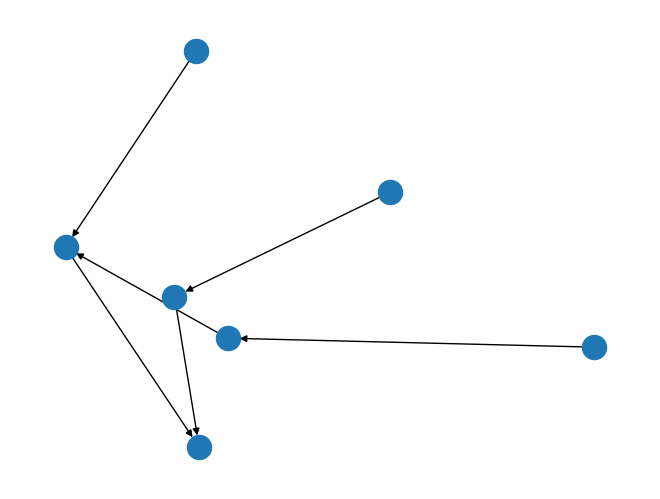

In [11]:
nx.draw(G)

In [12]:
save_dir = Path("../../data-cumberland/cumberland_rivreg/")
save_dir.mkdir(exist_ok=True)

G_gdf = gpd.GeoDataFrame(gnx.graph_edges_to_gdf(G))
G_gdf_pts = gpd.GeoDataFrame(gnx.graph_nodes_to_gdf(G))  # returns a pd.DF instead of gpd.GDF, although it has a geometry column

In [13]:
# add elevation data to nodes
elevation_fn = Path("../../global_data/global_elevation_data/World_e-Atlas-UCSD_SRTM30-plus_v8.tif")
elev = rxr.open_rasterio(elevation_fn, chunks='auto')

G_gdf_pts['elevation'] = G_gdf_pts[['x', 'y']].apply(lambda row: float(elev.sel(x=row.x, y=row.y, method='nearest')), axis=1)
G_gdf_pts.head()

,x,y,name,id,geometry,elevation
0,-84.267474,36.959995,Laurel_Dam,0,POINT (-84.26747 36.95999),301.0
1,-85.14375,36.867817,Wolf_Creek,1,POINT (-85.14375 36.86782),196.0
2,-85.450254,36.538312,Dale_Hollow_Dam,2,POINT (-85.45025 36.53831),195.0
3,-86.658869,36.29189,Old_Hickory_Dam,3,POINT (-86.65887 36.29189),131.0
4,-85.82558,36.096527,Center_Hill_Dam,4,POINT (-85.82558 36.09653),201.0


In [14]:
def slope_calculator(u, v, length, pts_gdf):
    return np.abs(pts_gdf.loc[u]['elevation'] - pts_gdf.loc[v]['elevation'])/length

# calculate slope
G_gdf['slope'] = G_gdf.apply(lambda row: slope_calculator(row.u, row.v, row.length, G_gdf_pts), axis=1)
G_gdf.head()

,u,v,length,geometry,slope
0,0,1,78657.642529,"LINESTRING (-84.26747 36.95999, -85.14375 36.8...",0.001335
1,1,6,95924.360233,"LINESTRING (-85.14375 36.86782, -85.94413 36.2...",0.000396
2,2,6,52007.174539,"LINESTRING (-85.45025 36.53831, -85.94413 36.2...",0.000711
3,4,3,77980.377335,"LINESTRING (-85.82558 36.09653, -86.65887 36.2...",0.000898
4,5,4,37602.202429,"LINESTRING (-85.62146 35.80104, -85.82558 36.0...",0.001782


,u,v,length,geometry,slope,R,n,velocity,travel_time
0,0,1,78657.642529,"LINESTRING (-84.26747 36.95999, -85.14375 36.8...",0.001335,3.333333,0.01,8.152861,0.111665
1,1,6,95924.360233,"LINESTRING (-85.14375 36.86782, -85.94413 36.2...",0.000396,3.333333,0.01,4.441331,0.249978
2,2,6,52007.174539,"LINESTRING (-85.45025 36.53831, -85.94413 36.2...",0.000711,3.333333,0.01,5.951892,0.101133
3,4,3,77980.377335,"LINESTRING (-85.82558 36.09653, -86.65887 36.2...",0.000898,3.333333,0.01,6.685628,0.134999
4,5,4,37602.202429,"LINESTRING (-85.62146 35.80104, -85.82558 36.0...",0.001782,3.333333,0.01,9.419256,0.046204


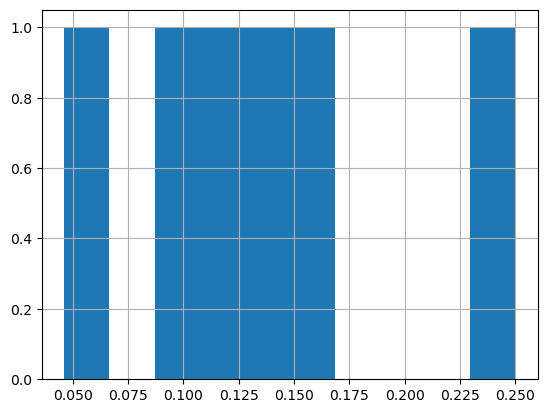

In [15]:
# assume manning's n
n = 0.01

# assume hydraulic radius R for now - change it later to parameterize it
A = 20*5    # rectangular stream, b=20, h=5
P = 20+5+5
G_gdf['R'] = A/P    # m

G_gdf['n'] = n
G_gdf['velocity'] = (1/G_gdf['n']) * G_gdf['R'].pow(2/3) * G_gdf['slope'].pow(1/2)  # m/s

G_gdf['travel_time'] = G_gdf['length'] / (G_gdf['velocity'] * (60*60*24))

G_gdf['travel_time'].hist()

G_gdf.head()

In [16]:
# save the files
G_gdf.to_file(save_dir / "cumberland_rivreg.shp")
G_gdf_pts.to_file(save_dir / "cumberland_rivreg_pts.shp")

# save the files
G_gdf.to_file(save_dir / "cumberland_rivreg.geojson")
G_gdf_pts.to_file(save_dir / "cumberland_rivreg_pts.geojson")

/tmp/ipykernel_25328/2131786406.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  G_gdf.to_file(save_dir / "cumberland_rivreg.shp")
